In [1]:
from graspologic import embed
import numpy as np
import pandas as pd
import scanpy as sc
from graspologic.embed.ase import AdjacencySpectralEmbed
from graspologic.embed.lse import LaplacianSpectralEmbed
from graspologic.embed import select_dimension
from graspologic.utils import is_symmetric, is_unweighted, largest_connected_component, symmetrize
from graspologic.plot import pairplot
from graspologic.cluster import AutoGMMCluster
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.preprocessing import normalize
from scipy.stats import spearmanr
import os
import matplotlib.pyplot as plt
import seaborn as sns
context = sns.plotting_context(context="talk", font_scale=0.8)
sns.set_context(context)


In [3]:

# import intermediary results from R
# sample R code:
# cell_cycle_markers <- readRDS("Accessory_data/cell_cycle_markers.rds")

# s_genes <- cell_cycle_markers %>%
#   dplyr::filter(phase == "S") %>%
#   pull("gene_name")

# g2m_genes <- cell_cycle_markers %>%
#   dplyr::filter(phase == "G2/M") %>%
#   pull("gene_name")

# snaps <- read.delim("Accessory_data/gene_snapshots_fb_2021_01.tsv", sep="\t", header=FALSE, comment.char="#", quote="", fill=FALSE)
# colnames(snaps) <- c("FBgn_ID", "GeneSymbol", "GeneName", "datestamp", "gene_snapshot_text")
# head(snaps)

# # sample_1

# s1.data <- Read10X("10X_data/Sample_1_SI-GA-A1_count_Sample_1/filtered_feature_bc_matrix")
# s1 <- CreateSeuratObject(counts = s1.data, project = "Sample_1", min.cells = 3,  min.features = 200)
# s1 <- RenameCells(object = s1, add.cell.id = "s1")
# s1

# s1[["percent.mt"]] <- PercentageFeatureSet(s1, pattern = "^mt:")
# s1 <- CellCycleScoring(s1, g2m.features = g2m_genes, s.features = s_genes)

# s1 <- SCTransform(s1, vars.to.regress = "percent.mt")
# s1 <- RunPCA(s1, npcs=100)

# s1 <- FindNeighbors(s1, dims = 1:40)
# s1 <- FindClusters(s1, resolution = c(0.05, 0.5, 1, 1.5, 2))

# s1 <- RunUMAP(s1, dims = 1:40)
# Idents(object = s1) <- 'SCT_snn_res.1'
# DimPlot(s1, reduction = "umap", label=TRUE)
# FeaturePlot(s1, features = c("brp", "nSyb", "elav", "Syt1","CadN"), label= TRUE, repel=TRUE )


# write.table(as.matrix(GetAssayData(object = s1[["SCT"]], slot = "data")), 
#             's1/SCT_log_trans_counts.csv', sep = ',', quote = F)
# umap_embed <- s1[["umap"]]@cell.embeddings
# write.table(umap_embed,
#             's1/umap_embed.csv', sep = ',', quote = F)
# pca_embed <- Embeddings(s1, reduction = "pca")[, 1:50]
# write.table(pca_embed,
#             's1/pca_embed.csv', sep = ',', quote = F)
# clusters <- s1[["seurat_clusters"]]
# write.table(clusters,
#             's1/clusters.csv', sep = ',', quote = F)

# s1.markers <- FindAllMarkers(s1, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
# s1.markers <- left_join(s1.markers, snaps, by = c("gene" = "GeneSymbol"), copy = TRUE)

# top20  <- s1.markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)
# DoHeatmap(s1, features = top20$gene) + NoLegend()

sample_id = 's1'
# SCT_residuals = pd.read_csv("Brainseq/"+sample_id+"/SCT_residuals.csv", index_col=0)
# SCT_residuals = SCT_residuals.to_numpy().T

meta = pd.read_csv("Brainseq/"+sample_id+"/SCT_log_trans_counts.csv", index_col=0)
SCT_log_trans_counts = meta.to_numpy().T

# SCT_counts = pd.read_csv("Brainseq/"+sample_id+"/SCT_counts.csv", index_col=0)
# SCT_counts = SCT_counts.to_numpy().T

pca_embed = pd.read_csv("Brainseq/"+sample_id+"/pca_embed.csv", index_col=0)
pca_embed = pca_embed.to_numpy()

umap_embed = pd.read_csv("Brainseq/"+sample_id+"/umap_embed.csv", index_col=0)
umap_embed = umap_embed.to_numpy()

clus = pd.read_csv("Brainseq/"+sample_id+"/clusters.csv", index_col=0)
clus = clus.to_numpy().reshape(-1,)


In [5]:
# kNN graph using Spearman correlation

k = 20
pca_dim = 40
def spearmancorr(x):
    rho, _ = spearmanr(x, axis=1)
    return 1-np.absolute(rho)

nn = NearestNeighbors(n_neighbors=k, metric='precomputed')
nn.fit(spearmancorr(pca_embed[:, :pca_dim]))
adj = nn.kneighbors_graph(n_neighbors=k, mode='connectivity')
adj = np.array(adj.todense())
np.fill_diagonal(adj, 1)
adj = symmetrize(adj)


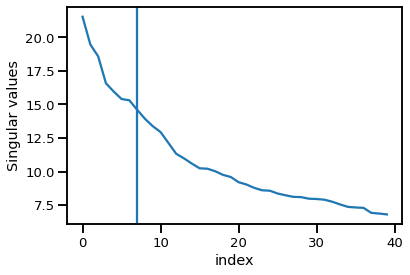

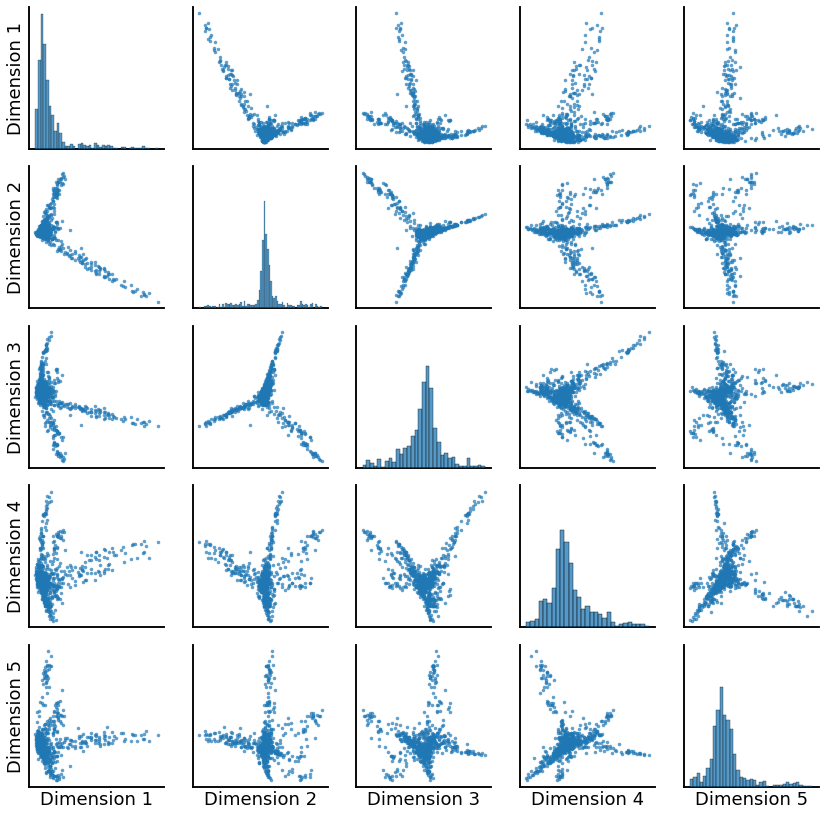

In [12]:
# spectral embedding

ase = AdjacencySpectralEmbed(40)
ase.fit(adj)
singular_values = ase.singular_values_
fig,ax = plt.subplots(1)
ax.plot(range(len(singular_values)), singular_values)

ase = AdjacencySpectralEmbed()
embedding = ase.fit_transform(adj)
ax.axvline(embedding.shape[1])
ax.set(xlabel='index', ylabel='Singular values')
plt.show()

pairplot(embedding[:, :5])


In [24]:
# Gaussian mixture modeling

n_comp = int(max(clus)+1)
agg = AutoGMMCluster(min_components=n_comp, max_components=n_comp)
pred = agg.fit_predict(embedding)
print(adjusted_rand_score(pred, clus))


0.4805187455771285


In [25]:
# marker genes for different cell types

feature_id = {}
feature_names_all = [["brp", "nSyb", "elav", "Syt1","CadN"],
    ["repo", "alrm", "Eaat1", "Gs1", "MFS9", "bnb","myr-GFP-p10", "nls-tdTomato"],
    ["N", "dpn", "Pen", "mira"]
    ]
for i in range(len(feature_names_all)):
    feature_id[i] = []
    for j in feature_names_all[i]:
        feature_id[i].append(meta.index.get_loc(j))


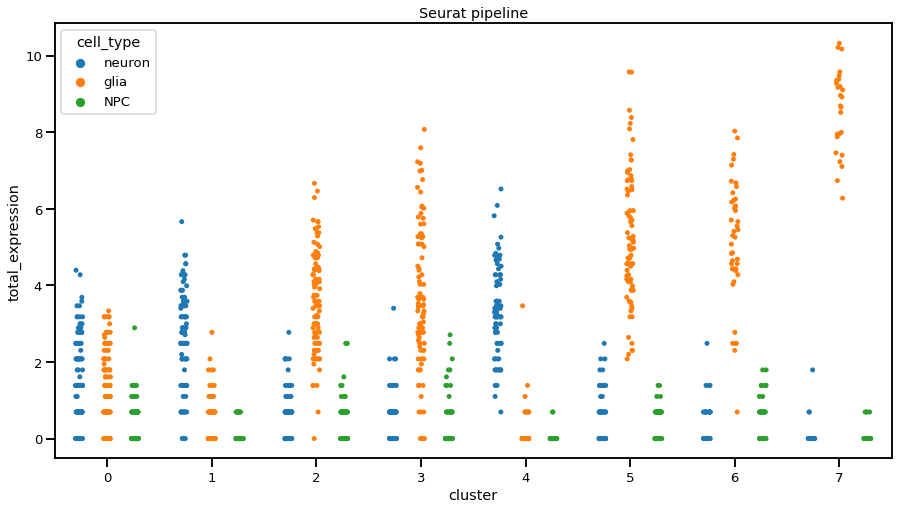

In [29]:
# total expression level of marker genes for each cell type

expn_overall = SCT_log_trans_counts.copy()
expn_all_cell_types = np.hstack((np.sum(expn_overall[:,feature_id[0]], axis=1),
    np.sum(expn_overall[:,feature_id[1]], axis=1),
    np.sum(expn_overall[:,feature_id[2]], axis=1)))

df = pd.DataFrame(data={
    'total_expression': expn_all_cell_types,
    # 'cluster': np.hstack((pred, pred, pred)),
    'cluster': np.hstack((clus, clus, clus)),
    'cell_type': np.repeat(['neuron', 'glia', 'NPC'], len(clus))
})

fig,ax = plt.subplots(1, figsize=(15,8))
sns.stripplot(data=df, x='cluster', y='total_expression', hue='cell_type',
    dodge=True, ax=ax)
ax.set_title('Seurat pipeline')
plt.show()


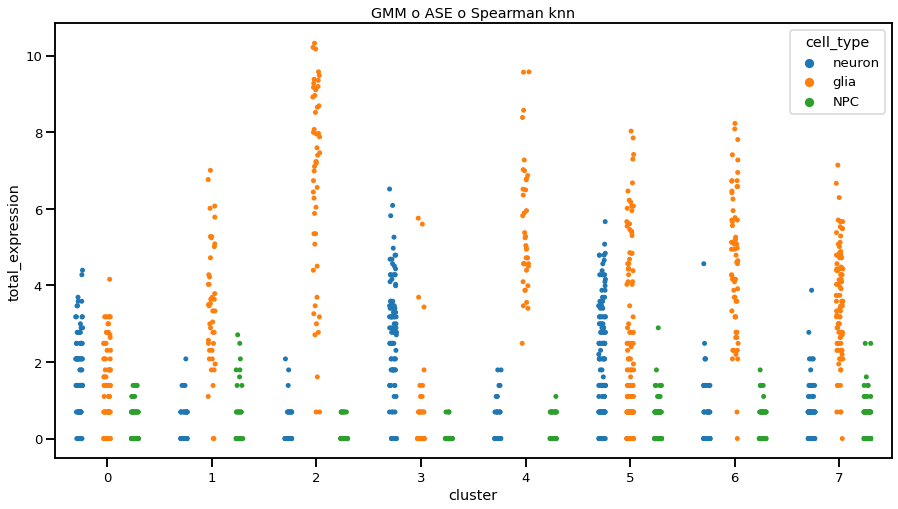

In [30]:
# total expression level of marker genes for each cell type

expn_overall = SCT_log_trans_counts.copy()
expn_all_cell_types = np.hstack((np.sum(expn_overall[:,feature_id[0]], axis=1),
    np.sum(expn_overall[:,feature_id[1]], axis=1),
    np.sum(expn_overall[:,feature_id[2]], axis=1)))

df = pd.DataFrame(data={
    'total_expression': expn_all_cell_types,
    'cluster': np.hstack((pred, pred, pred)),
    # 'cluster': np.hstack((clus, clus, clus)),
    'cell_type': np.repeat(['neuron', 'glia', 'NPC'], len(clus))
})

fig,ax = plt.subplots(1, figsize=(15,8))
sns.stripplot(data=df, x='cluster', y='total_expression', hue='cell_type',
    dodge=True, ax=ax)
ax.set_title('GMM o ASE o Spearman knn')
plt.show()
